In [1]:
import shutil
import re 
from glob import glob
import os
from tqdm import tqdm

import librosa
import soundfile as sf
import numpy as np 
import random
import pandas as pd
import matplotlib.pyplot as plt

from functional import *
from overlap import get_trimmed_sample, overlap_using_min
from predictor import get_VAD

In [2]:
sr = 16000

In [3]:
paths = {'root': 'F:/ISSAI_KSC2_unpacked',
         'src_csv': 'C:/Users/b.smadiarov/Diploma/VoiceDetectionForKazakhSpeech/data/annotation/Csv', 
         'trimmed': 'F:/ISSAI_KSC2_unpacked/trimmed', 
         'dihard_data': 'F:/ISSAI_KSC2_unpacked/diahard_data' 
        }

glob_paths = {'KS2_raw': 'F:/ISSAI_KSC2_unpacked/ISSAI_KSC2/**/**/*.flac',
              "trimmed": 'F:/ISSAI_KSC2_unpacked/trimmed/**/**/*.flac'
             } 

#### Generate samples

ToDO: 
- Короткие записи сливались с короткими записями.

Критерий: нету посторонних звуков 
1. tts - только для text_to_speech
2. Самый лучший crowdsourced,
3. tv_news: эпортаж это обычно речь 
4. parlament: т.к. кричат с требун  
5. Ужасные - radio: т.к. играет вечно музыка, talkshow - тоже какая то дичь, podcast - казахские подкасты это не подкасты а радио.

Кроме памяти (мне ее жалко) и так же в аннотационных файлах указана путь до файла. Поэтому что бы придестеречься 
я решил оставить все как есть.

#### **1. Trimmed files.**

In [4]:
tracklist = get_audios_with_folder_name(['crowdsourced', 'tts', 'tv_news'], glob_paths['KS2_raw'])
print('Dataset total len:', len(tracklist))

Dataset total len: 516458


In [5]:
matching_files = []

for track in tqdm(tracklist):
    track = track.replace('\\', '/')
    csv_file = get_VAD(track, paths['src_csv'], sr=sr)
    df = pd.read_csv(csv_file)
    if len(df) == 3:  
        speech_sequence = df['speech'].values[:3]
        if list(speech_sequence) == [0, 1, 0]:
            matching_files.append(track)
    
print("File with need structer:", len(matching_files))

100%|████████████████████████████████████████████████████████████| 516458/516458 [03:18<00:00, 2607.18it/s]

File with need structer: 145138


In [9]:
matching_files[:2]

['F:/ISSAI_KSC2_unpacked/ISSAI_KSC2/Dev/crowdsourced/5f55bbc1759d2.flac',
 'F:/ISSAI_KSC2_unpacked/ISSAI_KSC2/Dev/crowdsourced/5f55bbc87ca87.flac']

Saving trimmed files

In [10]:
for t in tqdm(matching_files):
    trimmed_audio = get_trimmed_sample(t, sr, paths['src_csv'])
    folder = t.replace("ISSAI_KSC2/", "trimmed/").replace(f"/{get_file_name (t)}.flac", '')
    os.makedirs(folder, exist_ok=True)
    path_to_save = folder + f"/{get_file_name (t)}.flac"
    sf.write(path_to_save, trimmed_audio, samplerate = sr)

100%|█████████████████████████████████████████████████████████████| 145138/145138 [18:56<00:00, 127.71it/s]


Single Class Sample

In [11]:
for t in tqdm(tracklist):
    t = t.replace('\\', '/')
    csv_file = get_VAD(t, paths['src_csv'], sr=sr)
    df = pd.read_csv(csv_file)
    if isSingleClassSample(df):
        audio, sr = librosa.load(t, sr=sr)
        folder = t.replace("ISSAI_KSC2/", "trimmed/").replace(f"/{get_file_name (t)}.flac", '')
        os.makedirs(folder, exist_ok=True)
        path_to_save = folder + f"/{get_file_name (t)}.flac"
        sf.write(path_to_save, trimmed_audio, samplerate = sr)

100%|█████████████████████████████████████████████████████████████| 516458/516458 [09:36<00:00, 896.15it/s]


#### **2. Объединяем аудиодорожки**

Pipline: 
1. Есть большой набор данных - trimmed в нем только самые лучшие для задачи диаризации аудодорожки. Сэмплов достаточно много - поэтому будет переменная `total_amount`, которая будет брать уже от trimmed папки.
2. Далее т.к. мы объединяем аудиодорожки то нам нужно их по отдельности обрезанное сохранить или запомнить их общую длину в csv файлы. В csv файле будет храниться столбец `min_length`который будет означать общую минимальную длину. Это поможет экономить место на диске. Но из за этого будет долше проходить инициализация.

In [4]:
total_amount_percent = 0.1 # 10 %
# Примерное число которое я хочу ~ 2000 записей для начало
total_dataset_size = 100000
k = 2
seed = k
random.seed(seed)
np.random.seed(seed)

1. Число класстеров _k_
2. _Seed_ зависит от числа кластеров. Это сделанно для того что бы добавить не предусмотренность. Но таким образом есть опасность что модель просто выучит голоса нежели начнет.
3. Для каждого числа класстера можно брать разный датасет.
4. Перемешивать нужно для того "говорящие" не шли одним за другим.

In [5]:
def plot_ghist(tracklist, sr):
    durations = []
    for track in tqdm(tracklist):
        y, sr = librosa.load(track, sr=None)  # Загружаем аудио
        duration = librosa.get_duration(y=y, sr=sr)  # Длительность в секундах
        durations.append(duration)
    plt.hist(durations, bins=40, color='blue', edgecolor='black')  # Гистограмма
    plt.xlabel('Длина аудиодорожки (секунды)')
    plt.ylabel('Количество аудиодорожек')
    plt.grid(True)
    plt.show()

In [6]:
trimmed = glob(glob_paths['trimmed'])
trimmed = [t.replace('\\', '/') for t in trimmed]

In [7]:
random.seed(seed)
folders_name = [('Train/tts', 0.35), ('Train/crowdsourced', 0.85), ('Dev/', 1.0), ('Test/', 1.0)]
total_folders = []
for p_path, percent in folders_name:
    temp_arr = find_files_folders(p_path, trimmed)
    total_folders.append([random.sample(temp_arr, len(temp_arr)), percent])

tracklist = [track for p in total_folders for track in p[0]]

# tracklist = []
# for p in total_folders: 
    # if total_dataset_size * p[1] > len(p[0]):
    #     raise Exception('Error, havent enough audios')
    #     break
    # else:
        # tracklist.extend(p[0][:int(total_dataset_size * p[1])])

random.shuffle(tracklist)
print(f"Before cutting: {len(tracklist)}")
tracklist = tracklist[:int(total_dataset_size)]
print('After cutting:', len(tracklist))

Before cutting: 118578
After cutting: 100000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 27366/27366 [00:14<00:00, 1885.19it/s]


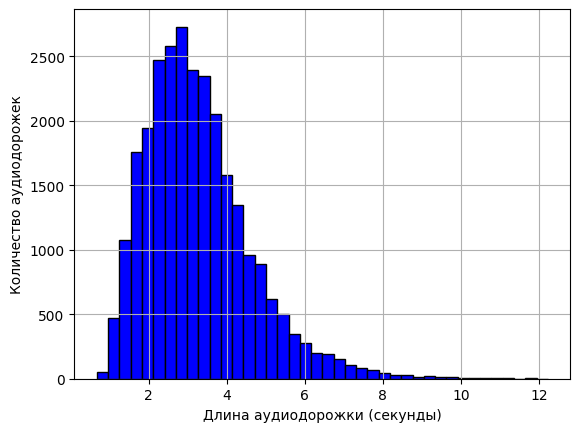

In [8]:
plot_ghist(total_folders[0][0], sr)

In [9]:
tracklist[:4]

['F:/ISSAI_KSC2_unpacked/trimmed/Test/tv_news/413222.flac',
 'F:/ISSAI_KSC2_unpacked/trimmed/Train/crowdsourced/5f54a7935a2c2.flac',
 'F:/ISSAI_KSC2_unpacked/trimmed/Train/crowdsourced/5f319196d9aa3.flac',
 'F:/ISSAI_KSC2_unpacked/trimmed/Train/crowdsourced/5f34de6117b87.flac']

Смешивание файлов
> Этот метод не нравится т.к. хочется что бы дорожка была как можно длинее. То есть аудио с одинаковой длины объединялись с одинаковыми аудио.

**Buckets sorting**

Распределение 

In [10]:
def plot_r_ghist (tracklist, sr):
    durations = []
    for track in tqdm(tracklist):
        y, sr = librosa.load(track, sr=None)  # Загружаем аудио
        duration = librosa.get_duration(y=y, sr=sr)  # Длительность в секундах
        durations.append(duration)
    min_duration = min(durations) if durations else 0
    max_duration = max(durations) if durations else 1
    bin_width = 0.5  # Ширина одного интервала
    bins = np.arange(min_duration, max_duration + bin_width, bin_width)
    plt.hist(durations, bins=bins, color='blue', edgecolor='black')  # Гистограмма
    plt.xlabel('Длина аудиодорожки (секунды)')
    plt.ylabel('Количество аудиодорожек')
    xticks = np.arange(0, max_duration + 1, step=bin_width)  # Шаг на 0.5 секунд
    plt.xticks(xticks, rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:53<00:00, 1863.85it/s]


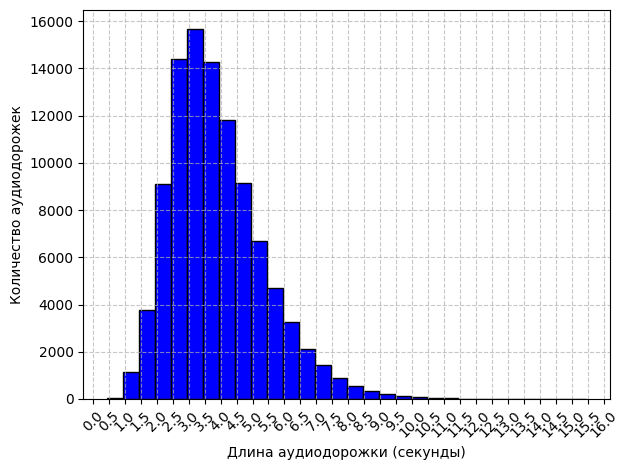

In [11]:
plot_r_ghist(tracklist, sr)

In [12]:
def sort_to_buckets (tracklist, sr):
    first_bucket = [] # audios in [1, 2] sec + [5, 8] sec
    second_bucket = [] # audios in [2.5, 4] sec
    third_bucket = [] + [] # audios in [2, 2.5] sec or [4, 5] sec
    non_predicted = 0
    for track in tqdm(tracklist):
        track = track.replace('\\', '/')
        y, sr = librosa.load(track, sr=sr)  
        duration = librosa.get_duration(y=y, sr=sr)  
        if 1.0 < duration < 2.0 or 5.5 < duration <= 8.0:
            first_bucket.append(track)
        elif 2.5 <= duration <= 4.0:
            second_bucket.append(track)
        elif 2.0 <= duration < 2.5 or 4.0 < duration <= 5.5:
            third_bucket.append(track)
        else:
            non_predicted += 1
            continue
            
    res = [first_bucket, second_bucket, third_bucket]
    return res, non_predicted

In [13]:
buckets, non_predicted = sort_to_buckets(tracklist, sr)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:54<00:00, 1833.66it/s]


In [14]:
data_sz = sum(len(bucket) for bucket in buckets) 
print('Data size', data_sz)

Data size 98498


##### First attemp | Depricated

In [10]:
# Этот метод не нравится т.к. хочется что бы дорожка была как можно длинее.
# То есть аудио с одинаковой длины объединялись с одинаковыми аудио.

# код работает только для двух аудиодорожек
for i in tqdm(range(0, len(tracklist), k)):
    tracks = tracklist[i:i+k]
    tracks = sorted(tracks)
    overlay, min_length = overlap_using_min(tracks)
    audio_names = "_".join([get_file_name(t) for t in tracks])
    audio_name = f"{paths['root']}/train_tvnews_crowdsourced_tts_mixed_{k}/{audio_names}.flac"
    sf.write(f"{audio_name}", overlay, samplerate=16000)
    df = pd.DataFrame({'mixed_audio': [audio_name],
                       'common_len_idx': [min_length],
                       **{f'audio_{j+1}': [t.replace('\\', '/')] for j, t in enumerate(tracks)}})
    df.to_csv(f"{audio_name.replace('.flac', '.csv')}", index=False)

100%|█████████████████████████████████████████████████████████████████| 5000/5000 [00:31<00:00, 161.20it/s]


##### Second attemp | 

In [15]:
import os
from tqdm import tqdm
import librosa
import pandas as pd
from align import relative_normalize_audio

sample_rate = 16000
common_folder = f"{paths['root']}/diahard_data/tvnews_crowdsourced_tts_mixed_{total_dataset_size}_{k}"
os.makedirs(common_folder, exist_ok=True)
os.makedirs(f"{common_folder}/mixed_{k}", exist_ok=True)

In [17]:
for tracklist in tqdm(buckets):
    for i in range(0, len(tracklist), k):
        tracks = tracklist[i:i+k]
        if len(tracks) != k: #  len(tracklist) % k == 0 or for i in range(0, len(tracklist)-1, k):
            break
        tracks = sorted(tracks)
        # Overlapping and normalize
        signals = []
        for audio_path in tracks:
            signal, sr = librosa.load(audio_path, sr=None)
            if sr != sample_rate:
                signal = librosa.resample(signal, orig_sr=sr, target_sr=sample_rate)
            signals.append(signal)
        min_length = min(len(audio) for audio in signals)
        signals = [s[:min_length] for s in signals]
        overlay, cleans = relative_normalize_audio(signals)
        # Naming, saving '.flac' and '.csv'
        overlap_audio_name = f"{common_folder}/mixed_{k}/{'_'.join([get_file_name(t) for t in tracks])}.flac"
        sf.write(overlap_audio_name, overlay, samplerate=sample_rate)
        clean_names = []
        for j, t in enumerate(tracks):
            spk_folder = f"{common_folder}/spk{j+1}"
            os.makedirs(spk_folder, exist_ok=True)
            clean_name = f"{spk_folder}/{get_file_name(t)}.flac"
            clean_names.append(clean_name)
            sf.write(clean_name, cleans[j], samplerate=sample_rate)
        df = pd.DataFrame({
            'mixed_audio': [overlap_audio_name],
            'common_len_idx': [min_length],
            **{f'audio_{j+1}': [clean_names[j].replace('\\', '/')] for j in range(len(clean_names))}
        })
        df.to_csv(overlap_audio_name.replace('.flac', '.csv'), index=False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [09:07<00:00, 182.51s/it]


In [18]:
# Get full dataset DF
annotations = glob(f"{common_folder}/mixed_{k}/*.csv")
all_dfs = []
for csv in tqdm(annotations):
    df = pd.read_csv(csv)
    all_dfs.append(df)

concated_df = pd.concat(all_dfs).reset_index(drop=True)
os.makedirs(f"F:/ISSAI_KSC2_unpacked/DIHARD_DATA_INFO", exist_ok=True)
concated_df.to_csv(f"F:/ISSAI_KSC2_unpacked/DIHARD_DATA_INFO/CONCATEDDFS_crowdsourced_tvnews_tts={total_dataset_size}_k={k}.csv", index=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 49248/49248 [00:21<00:00, 2304.20it/s]


In [19]:
print(f"Dataset size (Mixed num files): {len(concated_df)} for k = {k} clusters, total_amount_files: {len(tracklist)}")

Dataset size (Mixed num files): 49248 for k = 2 clusters, total_amount_files: 36387


#### Count mean and min chunk size

In [20]:
# trimmed = glob(glob_paths['trimmed'])
trimmed = glob(f"{common_folder}/mixed_{k}/*.flac")
trimmed = [t.replace('\\', '/') for t in trimmed]

In [21]:
durations = []
for t in tqdm(trimmed):
    audio, sample_rate = librosa.load(t, sr=None)
    durations.append(len(audio) / sample_rate)

samples = []
for duration in tqdm(durations):
    samples.append(int(duration * sample_rate))
least_size = min(samples)
avg_chunk_size = sum(samples) // len(samples)
return least_size, avg_chunk_size

print(f"Минимальный размер (least_size): {least_size} отсчетов")
print(f"Средний размер (chunk_size): {avg_chunk_size} отсчетов")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 49248/49248 [00:00<00:00, 3151872.00it/s]

Минимальный размер (least_size): 16400 отсчетов
Средний размер (chunk_size): 52243 отсчетов


#### To get need to data-format for training.

In [ ]:
# папка где хранять исходники для дириазации - они обрезанные без начало 'F:/ISSAI_KSC2_unpacked/trimmed',
# mixed_2 где хранять смешанные аудиодорожки для двух класстеров
# осторожно - нету папки где храняться targetы - вот эти и займемся

In [ ]:
# 1. Создаем все targetы
# 2. generate `.scp` file

In [ ]:
# Есть csv файл нужно 
# Я хочу сохранить audio_1, audio_2 в отдельные папки 
# Папки будет две - одна tr - train, другая cv - validation
# В каждой внутри папки есть mix и 

In [28]:
# 1. Делим один csv файла на два. 
k = 2
csv_path = f"F:/ISSAI_KSC2_unpacked/DIHARD_DATA_INFO/CONCATED_DFS_tts=2000_k_{2}.csv"
all_df = pd.read_csv(csv_path)
half_index = int(len(all_df) * 0.8)
df1 = all_df.iloc[:half_index]
df2 = all_df.iloc[half_index:]
df1.to_csv(f"F:/ISSAI_KSC2_unpacked/DIHARD_DATA_INFO/train_k_{k}.csv", index=False)
df2.to_csv(f"F:/ISSAI_KSC2_unpacked/DIHARD_DATA_INFO/valid_k_{k}.csv", index=False)

In [27]:
k = 2
csv_path = f"F:/ISSAI_KSC2_unpacked/DIHARD_DATA_INFO/train_k_{k}.csv"
df = pd.read_csv(csv_path)

for index, row in tqdm(df.iterrows(), total=len(df)):
    mixed_audio_path = row.iloc[0]
    stage = get_file_name(csv_path).split('_')[0]
    assert stage in ['train', 'valid'] 
    new_mx_audio_path = paths['dihard_data'] + f"/mixed_{k}/{stage}/mix/" + get_file_name (mixed_audio_path) + '.flac'
    shutil.move(mixed_audio_path, new_mx_audio_path)
    common_len = row.iloc[1]
    for column in range(2, len(full_df.columns)):
        raw_pth_name = row.iloc[column]
        audio, sr = librosa.load(raw_pth_name, sr=sr)
        stage = get_file_name(csv_path).split('_')[0]
        assert stage in ['train', 'valid'] 
        folder_name = f"{paths['dihard_data']}/mixed_{k}/{stage}/s{column-k+1}"
        new_path_file_name = f"{folder_name}/{get_file_name(raw_pth_name)}.flac"
        sf.write(f"{new_path_file_name}", audio[:common_len], samplerate=16000)

  0%|          | 0/800 [00:00<?, ?it/s]

In [ ]:
k = 2
csv_path = f"F:/ISSAI_KSC2_unpacked/DIHARD_DATA_INFO/valid_k_{k}.csv"
df = pd.read_csv(csv_path)

for index, row in tqdm(df.iterrows(), total=len(df)):
    mixed_audio_path = row.iloc[0]
    stage = get_file_name(csv_path).split('_')[0]
    assert stage in ['train', 'valid'] 
    new_mx_audio_path = paths['dihard_data'] + f"/mixed_{k}/{stage}/mix/" + get_file_name (mixed_audio_path) + '.flac'
    shutil.move(mixed_audio_path, new_mx_audio_path)
    common_len = row.iloc[1]
    for column in range(2, len(full_df.columns)):
        raw_pth_name = row.iloc[column]
        audio, sr = librosa.load(raw_pth_name, sr=sr)
        stage = get_file_name(csv_path).split('_')[0]
        assert stage in ['train', 'valid'] 
        folder_name = f"{paths['dihard_data']}/mixed_{k}/{stage}/s{column-k+1}"
        new_path_file_name = f"{folder_name}/{get_file_name(raw_pth_name)}.flac"
        sf.write(f"{new_path_file_name}", audio[:common_len], samplerate=16000)

In [37]:
# 2.

import os

# Пути и файлы для записи
datasets = {
    "train": {
        "mix": "F:/ISSAI_KSC2_unpacked/diahard_data/mixed_2/train/mix",
        "s1": "F:/ISSAI_KSC2_unpacked/diahard_data/mixed_2/train/s1",
        "s2": "F:/ISSAI_KSC2_unpacked/diahard_data/mixed_2/train/s2",
        "scp": {
            "mix": "tr_mix.scp",
            "s1": "tr_s1.scp",
            "s2": "tr_s2.scp",
        },
    },
    "cv": {
        "mix": "F:/ISSAI_KSC2_unpacked/diahard_data/mixed_2/valid/mix",
        "s1": "F:/ISSAI_KSC2_unpacked/diahard_data/mixed_2/valid/s1",
        "s2": "F:/ISSAI_KSC2_unpacked/diahard_data/mixed_2/valid/s2",
        "scp": {
            "mix": "cv_mix.scp",
            "s1": "cv_s1.scp",
            "s2": "cv_s2.scp",
        },
    },
}

# Функция для записи данных в SCP-файл
def write_scp(input_dir, output_file):
    with open(output_file, "w") as f:
        for root, _, files in os.walk(input_dir):
            files.sort()
            for file in files:
                f.write(f"{file} {os.path.join(root, file)}\n")

# Генерация SCP-файлов для всех наборов данных
for split, paths in datasets.items():
    for key, input_dir in paths.items():
        if key == "scp":  # Пропустить словарь с именами файлов
            continue
        write_scp(input_dir, paths["scp"][key])